# Basis-Function Meta-Learaning for Rapid Introspective Neural Adaptation (RINA) - E2E Baseline Training

This script loads quadrotor flight data in different wind conditions, trains a wind invariant representation of the unmodeled aerodynamics, and tests the performance of the model when adapting to new data in different wind conditions. 

## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
torch.set_default_tensor_type('torch.DoubleTensor')
from torch.utils.data.dataset import random_split
import os 
import utils
import mlmodel

from datetime import datetime
import re

/home/oyoungquist/.conda/envs/rina/lib/python3.11/site-packages/torch/__init__.py:747: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/torch/csrc/tensor/python_tensor.cpp:431.)
  _C._set_default_tensor_type(t)


In [2]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

True
1


In [3]:
import sys
if sys.platform == 'win32':
    NUM_WORKERS = 0 # Windows does not support multiprocessing
else:
    NUM_WORKERS = 2
print('running on ' + sys.platform + ', setting ' + str(NUM_WORKERS) + ' workers')

running on linux, setting 2 workers


## Load the data and create some simple visualizations

In [4]:
# features = ['q', 'q_dot', 'tau_cmd']
features = ["body_rp", "q", "body_rp_dot", "q_dot", "tau_cmd"]
label = 'tau_residual_cmd_cs'

labels = ["FR_hip", "FR_knee", "FR_foot", "FL_hip", "FL_knee", "FL_foot",
          "RR_hip", "RR_knee", "RR_foot", "RL_hip", "RL_knee", "RL_foot"]

# Training data collected from the neural-fly drone
dataset = 'rina' 
# dataset_folder = '/home/hcr/Research/DARoSLab/DARoS-Core/lcm_converted_log/05_17_2024_formal/training_data_ex/'
# testdata_folder = "/home/hcr/Research/DARoSLab/DARoS-Core/lcm_converted_log/05_17_2024_formal/eval_data_ex/"


dataset_folder = '/home/oyoungquist/Research/RINA/rina/data/lcm_converted_log/06_24_2024_formal/training_data_cs/'
testdata_folder = "/home/oyoungquist/Research/RINA/rina/data/lcm_converted_log/06_24_2024_formal/eval_data_cs/"

use_discrim = False


now = datetime.now() # current date and time
date_time = now.strftime("%m/%d/%Y%H:%M:%S")
date_time = re.sub('[^0-9a-zA-Z]+', '_', date_time)

date_time += "_cmd_residual_cc_baseline_no_dis_no_sn_10000epochs"

cwd = os.getcwd()

output_path_base = os.path.join(cwd, "training_results", "baseline_models", "cmd_residual_cs", "extened_state", date_time)

if not os.path.exists(output_path_base):
    os.makedirs(output_path_base)

print(output_path_base)

# # Training data collected from an intel aero drone
# dataset = 'neural-fly-transfer'
# dataset_folder = 'data/training-transfer'
# hover_pwm = 910 # mean hover pwm for neural-fly drone
# intel_hover_pwm = 1675 # mean hover pwm for intel-aero drone
# hover_pwm_ratio = hover_pwm / intel_hover_pwm # scaling ratio from system id

modelname = f"{dataset}_e2e_baseline_{'-'.join(features)}" # 'intel-aero_fa-num-Tsp_v-q-pwm'

print(modelname)

/home/oyoungquist/Research/RINA/rina/training_results/baseline_models/cmd_residual_cs/extened_state/07_23_202421_07_02_cmd_residual_cc_baseline_no_dis_no_sn_10000epochs
rina_e2e_baseline_body_rp-q-body_rp_dot-q_dot-tau_cmd


In [5]:
RawData = utils.load_data(dataset_folder)
Data = utils.format_data(RawData, features=features, output=label, body_offset=0)

print("\n-----------------------------------------------\n")

RawData = utils.load_data(testdata_folder) # expnames='(baseline_)([0-9]*|no)wind'
TestData = utils.format_data(RawData, features=features, output=label, body_offset=0) # wind condition label, C, will not make sense for this data - that's okay since C is only used in the training process


-----------------------------------------------



In [6]:
# training_data_images = os.path.join(output_path_base, "training_data_images")
# test_data_images = os.path.join(output_path_base, "test_data_images")

# if not os.path.exists(training_data_images):
#     os.makedirs(training_data_images)

# if not os.path.exists(test_data_images):
#     os.makedirs(test_data_images)

# for data in Data:
#     utils.plot_subdataset(data, features, labels, os.path.join(training_data_images, "{:s}.png".format(data.meta['condition'])), title_prefix="(Training data)")

# for data in TestData:
#     utils.plot_subdataset(data, features, labels, os.path.join(test_data_images, "{:s}.png".format(data.meta['condition'])), title_prefix="(Testing Data)")

## Initialize some other hyperparameters

In [7]:
options = {}
options['dim_x'] = Data[0].X.shape[1]
options['dim_y'] = Data[0].Y.shape[1]
options['num_c'] = len(Data)
print('dims of (x, y) are', (options['dim_x'], options['dim_y']))
print('there are ' + str(options['num_c']) + ' different conditions')

dims of (x, y) are (40, 12)
there are 3 different conditions


In [8]:
# Set hyperparameters
options['features'] = features
options['loss_type'] = 'crossentropy-loss'

options['shuffle'] = True # True: shuffle trajectories to data points
# options['K_shot'] = 32 # number of K-shot for least square on a
options['phi_shot'] = 2048 # batch size for training phi

# options['alpha'] = 0.01 # adversarial regularization loss
# options['alpha'] = 0.055 # adversarial regularization loss


# options['learning_rate'] = 5e-4
# options['learning_rate'] = 0.001497
options['frequency_h'] = 2 # how many times phi is updated between h updates, on average
# options['SN'] = 2. # maximum single layer spectral norm of phi
# options['SN'] = 4. # maximum single layer spectral norm of phi
# options['gamma'] = 10. # max 2-norm of a
options['num_epochs'] = 10000

options['K_shot'] = 50 # number of K-shot for least square on a
options['alpha'] = 0.0236 # adversarial regularization loss
options['SN'] = 6. # maximum single layer spectral norm of phi
options['gamma'] = 10. # max 2-norm of a
options['learning_rate'] = 0.00276

options['phi_shot'] = 2048 # batch size for training phi


options['phi_first_out'] = 100
options['phi_second_out'] = 128
options['discrim_hidden'] = 40

options['output_path'] = output_path_base
options['device'] = device

# Dataset Generation

The adaptation dataset will be used to update $a$ in each training loop.
The training dataset will be used to train $\phi$ in each training loop.

In [9]:
# Trainset = []
# Adaptset = []
Trainloader = []
Adaptloader = []
for i in range(options['num_c']):
    fullset = mlmodel.MyDataset(Data[i].X, Data[i].Y, Data[i].C)
    
    l = len(Data[i].X)
    if options['shuffle']:
        trainset, adaptset = random_split(fullset, [int(2/3*l), l-int(2/3*l)])
    else:
        trainset = mlmodel.MyDataset(Data[i].X[:int(2/3*l)], Data[i].Y[:int(2/3*l)], Data[i].C) 
        adaptset = mlmodel.MyDataset(Data[i].X[int(2/3*l):], Data[i].Y[int(2/3*l):], Data[i].C)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=options['phi_shot'], shuffle=options['shuffle'], num_workers=NUM_WORKERS)
    adaptloader = torch.utils.data.DataLoader(adaptset, batch_size=options['K_shot'], shuffle=options['shuffle'], num_workers=NUM_WORKERS)
   
    # Trainset.append(trainset)
    # Adaptset.append(adaptset)
    Trainloader.append(trainloader) # for training phi
    Adaptloader.append(adaptloader) # for LS on a

# Initialize the models

In [10]:
# Store the model class definition in an external file so they can be referenced outside this script
phi_net = mlmodel.E2E_Phi_Net(options)
h_net = None

# push to GPU
phi_net.to(device)

if use_discrim:
    h_net = mlmodel.E2E_H_Net_CrossEntropy(options)
    h_net.to(device)

In [11]:
criterion = nn.MSELoss()
optimizer_phi = optim.Adam(phi_net.parameters(), lr=options['learning_rate'])
criterion_h = None
optimizer_h = None

if use_discrim:
    criterion_h = nn.CrossEntropyLoss()
    optimizer_h = optim.Adam(h_net.parameters(), lr=options['learning_rate'])

In [12]:
model_save_freq = 50 # How often to save the model

# Create some arrays to save training statistics
Loss_f = [] # combined force prediction loss
Loss_c = [] # combined adversarial loss

# Loss for each subdataset 
Loss_test_nominal = [] # loss without any learning
Loss_test_mean = [] # loss with mean predictor
Loss_test_phi = [] # loss with NN
for i in range(len(TestData)):
    Loss_test_nominal.append([])
    Loss_test_mean.append([])
    Loss_test_phi.append([])

# Training!
for epoch in range(options['num_epochs']):
    # Randomize the order in which we train over the subdatasets
    arr = np.arange(options['num_c'])
    np.random.shuffle(arr)

    # Running loss over all subdatasets
    running_loss_f = 0.0
    running_loss_c = 0.0

    phi_net.to(device)

    if use_discrim:
        h_net.to(device)

    for i in arr:
        with torch.no_grad():
            trainloader = Trainloader[i]
            data = next(iter(trainloader))
        
        optimizer_phi.zero_grad()
            
        '''
        Batch training \phi_net
        '''
        inputs = data['input'].to(device) # B x dim_x
        labels = data['output'].to(device) # B x dim_y
        
        c_labels = data['c'].type(torch.long).to(device)
            
        # forward + backward + optimize
        outputs = phi_net(inputs)
        loss_f = criterion(outputs, labels)
        temp = phi_net(inputs)
        
        loss_c = None
        loss_phi = None
        if use_discrim:
            loss_c = criterion_h(h_net(temp), c_labels)    
            loss_phi = loss_f - options['alpha'] * loss_c
        else:
            loss_phi = loss_f
        
        loss_phi.backward()
        optimizer_phi.step()
        
        '''
        Discriminator training
        '''
        if np.random.rand() <= 1.0 / options['frequency_h'] and use_discrim:
            optimizer_h.zero_grad()
            temp = phi_net(inputs)
            
            loss_c = criterion_h(h_net(temp), c_labels)
            
            loss_h = loss_c
            loss_h.backward()
            optimizer_h.step()
        
        # '''
        # Spectral normalization
        # '''
        # # push network to CPU for normalization
        # phi_net.to('cpu')
        # if options['SN'] > 0:
        #     for param in phi_net.parameters():
        #         M = param.detach().numpy()
        #         if M.ndim > 1:
        #             s = np.linalg.norm(M, 2)
        #             if s > options['SN']:
        #                 param.data = param / s * options['SN']
         
        # # push network to device
        # phi_net.to(device)
        
        running_loss_f += loss_f.cpu().item()
        
        if use_discrim:
            running_loss_c += loss_c.cpu().item()

        # push data back to cpu
        inputs.to('cpu')
        labels.to('cpu')
        c_labels.to('cpu')
    
    # Save statistics
    Loss_f.append(running_loss_f / options['num_c'])

    if use_discrim:
        Loss_c.append(running_loss_c / options['num_c'])
    if epoch % 10 == 0:
        if use_discrim:
            print('[%d] loss_f: %.2f' % (epoch + 1, running_loss_f / options['num_c']))
        else:
            print('[%d] loss_f: %.2f loss_c: %.2f' % (epoch + 1, running_loss_f / options['num_c'], running_loss_c / options['num_c']))
        
    with torch.no_grad():
        for j in range(len(TestData)):
            loss_nominal, loss_mean, loss_phi = mlmodel.error_statistics_e2e(TestData[j].X, TestData[j].Y, phi_net, h_net, options=options)
            Loss_test_nominal[j].append(loss_nominal)
            Loss_test_mean[j].append(loss_mean)
            Loss_test_phi[j].append(loss_phi)

    if epoch % model_save_freq == 0:
        mlmodel.save_model(phi_net=phi_net, h_net=h_net, modelname=modelname + '-epoch-' + str(epoch), options=options)

mlmodel.save_model(phi_net=phi_net, h_net=h_net, modelname=modelname + '-epoch-' + str(options["num_epochs"]), options=options)

[1] loss_f: 6.88 loss_c: 0.00
[11] loss_f: 4.80 loss_c: 0.00
[21] loss_f: 3.26 loss_c: 0.00
[31] loss_f: 2.67 loss_c: 0.00
[41] loss_f: 2.54 loss_c: 0.00
[51] loss_f: 2.17 loss_c: 0.00
[61] loss_f: 1.98 loss_c: 0.00
[71] loss_f: 1.90 loss_c: 0.00
[81] loss_f: 1.80 loss_c: 0.00
[91] loss_f: 1.79 loss_c: 0.00
[101] loss_f: 1.75 loss_c: 0.00
[111] loss_f: 1.59 loss_c: 0.00


Traceback (most recent call last):
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 303, in _run_finalizers
    finalizer()
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 227, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 136, in _remove_temp_dir
    rmtree(tempdir, onerror=onerror)
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/shutil.py", line 763, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/shutil.py", line 761, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-0u1yi19m'


[121] loss_f: 1.67 loss_c: 0.00
[131] loss_f: 1.61 loss_c: 0.00
[141] loss_f: 1.58 loss_c: 0.00
[151] loss_f: 1.65 loss_c: 0.00
[161] loss_f: 1.47 loss_c: 0.00
[171] loss_f: 1.52 loss_c: 0.00
[181] loss_f: 1.54 loss_c: 0.00
[191] loss_f: 1.44 loss_c: 0.00
[201] loss_f: 1.44 loss_c: 0.00
[211] loss_f: 1.44 loss_c: 0.00
[221] loss_f: 1.44 loss_c: 0.00
[231] loss_f: 1.42 loss_c: 0.00
[241] loss_f: 1.35 loss_c: 0.00
[251] loss_f: 1.40 loss_c: 0.00
[261] loss_f: 1.47 loss_c: 0.00
[271] loss_f: 1.42 loss_c: 0.00
[281] loss_f: 1.29 loss_c: 0.00
[291] loss_f: 1.36 loss_c: 0.00
[301] loss_f: 1.22 loss_c: 0.00
[311] loss_f: 1.32 loss_c: 0.00
[321] loss_f: 1.17 loss_c: 0.00
[331] loss_f: 1.22 loss_c: 0.00
[341] loss_f: 1.28 loss_c: 0.00
[351] loss_f: 1.33 loss_c: 0.00
[361] loss_f: 1.27 loss_c: 0.00
[371] loss_f: 1.31 loss_c: 0.00
[381] loss_f: 1.19 loss_c: 0.00
[391] loss_f: 1.26 loss_c: 0.00
[401] loss_f: 1.19 loss_c: 0.00
[411] loss_f: 1.11 loss_c: 0.00
[421] loss_f: 1.16 loss_c: 0.00
[431] lo

Traceback (most recent call last):
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 303, in _run_finalizers
    finalizer()
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 227, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 136, in _remove_temp_dir
    rmtree(tempdir, onerror=onerror)
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/shutil.py", line 763, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/shutil.py", line 761, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-bkw2icb1'


[1011] loss_f: 0.91 loss_c: 0.00
[1021] loss_f: 0.94 loss_c: 0.00
[1031] loss_f: 0.86 loss_c: 0.00
[1041] loss_f: 0.99 loss_c: 0.00
[1051] loss_f: 0.94 loss_c: 0.00
[1061] loss_f: 0.88 loss_c: 0.00
[1071] loss_f: 0.93 loss_c: 0.00
[1081] loss_f: 0.90 loss_c: 0.00
[1091] loss_f: 0.88 loss_c: 0.00
[1101] loss_f: 0.94 loss_c: 0.00
[1111] loss_f: 0.96 loss_c: 0.00
[1121] loss_f: 0.92 loss_c: 0.00
[1131] loss_f: 0.93 loss_c: 0.00
[1141] loss_f: 0.86 loss_c: 0.00
[1151] loss_f: 0.85 loss_c: 0.00
[1161] loss_f: 0.88 loss_c: 0.00
[1171] loss_f: 0.94 loss_c: 0.00
[1181] loss_f: 0.92 loss_c: 0.00
[1191] loss_f: 0.84 loss_c: 0.00
[1201] loss_f: 0.84 loss_c: 0.00
[1211] loss_f: 0.89 loss_c: 0.00
[1221] loss_f: 0.86 loss_c: 0.00
[1231] loss_f: 0.86 loss_c: 0.00
[1241] loss_f: 0.95 loss_c: 0.00


Traceback (most recent call last):
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 303, in _run_finalizers
    finalizer()
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 227, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 136, in _remove_temp_dir
    rmtree(tempdir, onerror=onerror)
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/shutil.py", line 763, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/shutil.py", line 761, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-z39034mm'


[1251] loss_f: 0.84 loss_c: 0.00
[1261] loss_f: 1.01 loss_c: 0.00
[1271] loss_f: 0.89 loss_c: 0.00
[1281] loss_f: 0.84 loss_c: 0.00
[1291] loss_f: 0.87 loss_c: 0.00
[1301] loss_f: 0.83 loss_c: 0.00
[1311] loss_f: 0.86 loss_c: 0.00
[1321] loss_f: 0.82 loss_c: 0.00
[1331] loss_f: 0.82 loss_c: 0.00
[1341] loss_f: 0.79 loss_c: 0.00
[1351] loss_f: 0.90 loss_c: 0.00
[1361] loss_f: 0.80 loss_c: 0.00
[1371] loss_f: 0.86 loss_c: 0.00
[1381] loss_f: 0.94 loss_c: 0.00
[1391] loss_f: 0.93 loss_c: 0.00
[1401] loss_f: 0.89 loss_c: 0.00
[1411] loss_f: 0.95 loss_c: 0.00
[1421] loss_f: 0.85 loss_c: 0.00
[1431] loss_f: 0.83 loss_c: 0.00
[1441] loss_f: 0.97 loss_c: 0.00
[1451] loss_f: 0.82 loss_c: 0.00
[1461] loss_f: 0.86 loss_c: 0.00
[1471] loss_f: 0.83 loss_c: 0.00
[1481] loss_f: 0.90 loss_c: 0.00
[1491] loss_f: 0.87 loss_c: 0.00
[1501] loss_f: 0.81 loss_c: 0.00
[1511] loss_f: 0.85 loss_c: 0.00
[1521] loss_f: 0.84 loss_c: 0.00
[1531] loss_f: 0.85 loss_c: 0.00
[1541] loss_f: 0.90 loss_c: 0.00
[1551] los

Traceback (most recent call last):
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 303, in _run_finalizers
    finalizer()
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 227, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 136, in _remove_temp_dir
    rmtree(tempdir, onerror=onerror)
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/shutil.py", line 763, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/shutil.py", line 761, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-cyh5wuc2'


[2791] loss_f: 0.71 loss_c: 0.00
[2801] loss_f: 0.76 loss_c: 0.00
[2811] loss_f: 0.67 loss_c: 0.00
[2821] loss_f: 0.69 loss_c: 0.00
[2831] loss_f: 0.71 loss_c: 0.00
[2841] loss_f: 0.75 loss_c: 0.00
[2851] loss_f: 0.78 loss_c: 0.00
[2861] loss_f: 0.73 loss_c: 0.00
[2871] loss_f: 0.73 loss_c: 0.00
[2881] loss_f: 0.72 loss_c: 0.00
[2891] loss_f: 0.72 loss_c: 0.00
[2901] loss_f: 0.68 loss_c: 0.00
[2911] loss_f: 0.72 loss_c: 0.00
[2921] loss_f: 0.69 loss_c: 0.00
[2931] loss_f: 0.74 loss_c: 0.00
[2941] loss_f: 0.62 loss_c: 0.00
[2951] loss_f: 0.76 loss_c: 0.00
[2961] loss_f: 0.67 loss_c: 0.00
[2971] loss_f: 0.67 loss_c: 0.00
[2981] loss_f: 0.66 loss_c: 0.00
[2991] loss_f: 0.69 loss_c: 0.00
[3001] loss_f: 0.69 loss_c: 0.00
[3011] loss_f: 0.68 loss_c: 0.00
[3021] loss_f: 0.68 loss_c: 0.00
[3031] loss_f: 0.75 loss_c: 0.00
[3041] loss_f: 0.71 loss_c: 0.00
[3051] loss_f: 0.70 loss_c: 0.00
[3061] loss_f: 0.65 loss_c: 0.00
[3071] loss_f: 0.73 loss_c: 0.00
[3081] loss_f: 0.73 loss_c: 0.00
[3091] los

Traceback (most recent call last):
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 303, in _run_finalizers
    finalizer()
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 227, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 136, in _remove_temp_dir
    rmtree(tempdir, onerror=onerror)
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/shutil.py", line 763, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/shutil.py", line 761, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-0uer_go_'


[3351] loss_f: 0.69 loss_c: 0.00
[3361] loss_f: 0.69 loss_c: 0.00
[3371] loss_f: 0.67 loss_c: 0.00
[3381] loss_f: 0.67 loss_c: 0.00
[3391] loss_f: 0.66 loss_c: 0.00
[3401] loss_f: 0.72 loss_c: 0.00
[3411] loss_f: 0.67 loss_c: 0.00
[3421] loss_f: 0.69 loss_c: 0.00
[3431] loss_f: 0.62 loss_c: 0.00
[3441] loss_f: 0.64 loss_c: 0.00
[3451] loss_f: 0.68 loss_c: 0.00
[3461] loss_f: 0.70 loss_c: 0.00
[3471] loss_f: 0.68 loss_c: 0.00
[3481] loss_f: 0.70 loss_c: 0.00
[3491] loss_f: 0.68 loss_c: 0.00
[3501] loss_f: 0.61 loss_c: 0.00
[3511] loss_f: 0.67 loss_c: 0.00
[3521] loss_f: 0.73 loss_c: 0.00
[3531] loss_f: 0.71 loss_c: 0.00
[3541] loss_f: 0.64 loss_c: 0.00
[3551] loss_f: 0.76 loss_c: 0.00
[3561] loss_f: 0.70 loss_c: 0.00
[3571] loss_f: 0.67 loss_c: 0.00
[3581] loss_f: 0.75 loss_c: 0.00
[3591] loss_f: 0.73 loss_c: 0.00
[3601] loss_f: 0.66 loss_c: 0.00
[3611] loss_f: 0.69 loss_c: 0.00
[3621] loss_f: 0.64 loss_c: 0.00
[3631] loss_f: 0.78 loss_c: 0.00
[3641] loss_f: 0.71 loss_c: 0.00
[3651] los

Traceback (most recent call last):
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 303, in _run_finalizers
    finalizer()
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 227, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 136, in _remove_temp_dir
    rmtree(tempdir, onerror=onerror)
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/shutil.py", line 763, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/shutil.py", line 761, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-v0rt857a'


[6131] loss_f: 0.59 loss_c: 0.00
[6141] loss_f: 0.62 loss_c: 0.00
[6151] loss_f: 0.63 loss_c: 0.00


Traceback (most recent call last):
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 303, in _run_finalizers
    finalizer()
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 227, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 136, in _remove_temp_dir
    rmtree(tempdir, onerror=onerror)
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/shutil.py", line 763, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/shutil.py", line 761, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-dzs75x_m'


[6161] loss_f: 0.59 loss_c: 0.00
[6171] loss_f: 0.53 loss_c: 0.00
[6181] loss_f: 0.63 loss_c: 0.00
[6191] loss_f: 0.63 loss_c: 0.00
[6201] loss_f: 0.59 loss_c: 0.00
[6211] loss_f: 0.64 loss_c: 0.00
[6221] loss_f: 0.58 loss_c: 0.00
[6231] loss_f: 0.60 loss_c: 0.00
[6241] loss_f: 0.67 loss_c: 0.00
[6251] loss_f: 0.56 loss_c: 0.00
[6261] loss_f: 0.62 loss_c: 0.00
[6271] loss_f: 0.58 loss_c: 0.00
[6281] loss_f: 0.58 loss_c: 0.00
[6291] loss_f: 0.53 loss_c: 0.00
[6301] loss_f: 0.57 loss_c: 0.00
[6311] loss_f: 0.62 loss_c: 0.00
[6321] loss_f: 0.59 loss_c: 0.00
[6331] loss_f: 0.57 loss_c: 0.00
[6341] loss_f: 0.60 loss_c: 0.00
[6351] loss_f: 0.58 loss_c: 0.00
[6361] loss_f: 0.60 loss_c: 0.00
[6371] loss_f: 0.61 loss_c: 0.00
[6381] loss_f: 0.56 loss_c: 0.00
[6391] loss_f: 0.59 loss_c: 0.00
[6401] loss_f: 0.62 loss_c: 0.00
[6411] loss_f: 0.60 loss_c: 0.00
[6421] loss_f: 0.58 loss_c: 0.00
[6431] loss_f: 0.61 loss_c: 0.00
[6441] loss_f: 0.65 loss_c: 0.00
[6451] loss_f: 0.60 loss_c: 0.00
[6461] los

Traceback (most recent call last):
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 303, in _run_finalizers
    finalizer()
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 227, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 136, in _remove_temp_dir
    rmtree(tempdir, onerror=onerror)
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/shutil.py", line 763, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/shutil.py", line 761, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-mod0s8ya'


[6651] loss_f: 0.53 loss_c: 0.00
[6661] loss_f: 0.57 loss_c: 0.00
[6671] loss_f: 0.61 loss_c: 0.00
[6681] loss_f: 0.61 loss_c: 0.00
[6691] loss_f: 0.65 loss_c: 0.00
[6701] loss_f: 0.55 loss_c: 0.00
[6711] loss_f: 0.59 loss_c: 0.00
[6721] loss_f: 0.58 loss_c: 0.00
[6731] loss_f: 0.56 loss_c: 0.00


Traceback (most recent call last):
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 303, in _run_finalizers
    finalizer()
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 227, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 136, in _remove_temp_dir
    rmtree(tempdir, onerror=onerror)
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/shutil.py", line 763, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/shutil.py", line 761, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-ts0h5xm0'


[6741] loss_f: 0.66 loss_c: 0.00
[6751] loss_f: 0.58 loss_c: 0.00
[6761] loss_f: 0.59 loss_c: 0.00
[6771] loss_f: 0.60 loss_c: 0.00
[6781] loss_f: 0.57 loss_c: 0.00
[6791] loss_f: 0.55 loss_c: 0.00
[6801] loss_f: 0.60 loss_c: 0.00
[6811] loss_f: 0.62 loss_c: 0.00
[6821] loss_f: 0.61 loss_c: 0.00
[6831] loss_f: 0.56 loss_c: 0.00
[6841] loss_f: 0.58 loss_c: 0.00
[6851] loss_f: 0.53 loss_c: 0.00
[6861] loss_f: 0.61 loss_c: 0.00
[6871] loss_f: 0.63 loss_c: 0.00
[6881] loss_f: 0.62 loss_c: 0.00
[6891] loss_f: 0.53 loss_c: 0.00
[6901] loss_f: 0.58 loss_c: 0.00
[6911] loss_f: 0.64 loss_c: 0.00
[6921] loss_f: 0.56 loss_c: 0.00
[6931] loss_f: 0.65 loss_c: 0.00
[6941] loss_f: 0.57 loss_c: 0.00
[6951] loss_f: 0.54 loss_c: 0.00
[6961] loss_f: 0.57 loss_c: 0.00
[6971] loss_f: 0.57 loss_c: 0.00


Traceback (most recent call last):
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 303, in _run_finalizers
    finalizer()
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 227, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 136, in _remove_temp_dir
    rmtree(tempdir, onerror=onerror)
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/shutil.py", line 763, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/shutil.py", line 761, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-akq11imj'


[6981] loss_f: 0.58 loss_c: 0.00
[6991] loss_f: 0.58 loss_c: 0.00
[7001] loss_f: 0.54 loss_c: 0.00
[7011] loss_f: 0.55 loss_c: 0.00
[7021] loss_f: 0.65 loss_c: 0.00
[7031] loss_f: 0.57 loss_c: 0.00
[7041] loss_f: 0.54 loss_c: 0.00
[7051] loss_f: 0.55 loss_c: 0.00
[7061] loss_f: 0.57 loss_c: 0.00
[7071] loss_f: 0.52 loss_c: 0.00
[7081] loss_f: 0.57 loss_c: 0.00
[7091] loss_f: 0.56 loss_c: 0.00
[7101] loss_f: 0.63 loss_c: 0.00
[7111] loss_f: 0.61 loss_c: 0.00
[7121] loss_f: 0.57 loss_c: 0.00
[7131] loss_f: 0.55 loss_c: 0.00
[7141] loss_f: 0.58 loss_c: 0.00
[7151] loss_f: 0.55 loss_c: 0.00
[7161] loss_f: 0.57 loss_c: 0.00
[7171] loss_f: 0.57 loss_c: 0.00
[7181] loss_f: 0.61 loss_c: 0.00
[7191] loss_f: 0.57 loss_c: 0.00
[7201] loss_f: 0.57 loss_c: 0.00
[7211] loss_f: 0.56 loss_c: 0.00
[7221] loss_f: 0.57 loss_c: 0.00
[7231] loss_f: 0.56 loss_c: 0.00
[7241] loss_f: 0.62 loss_c: 0.00
[7251] loss_f: 0.57 loss_c: 0.00
[7261] loss_f: 0.55 loss_c: 0.00
[7271] loss_f: 0.52 loss_c: 0.00
[7281] los

Traceback (most recent call last):
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 303, in _run_finalizers
    finalizer()
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 227, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 136, in _remove_temp_dir
    rmtree(tempdir, onerror=onerror)
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/shutil.py", line 763, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/shutil.py", line 761, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-nm3rwmij'


[7911] loss_f: 0.53 loss_c: 0.00
[7921] loss_f: 0.56 loss_c: 0.00
[7931] loss_f: 0.58 loss_c: 0.00
[7941] loss_f: 0.55 loss_c: 0.00
[7951] loss_f: 0.56 loss_c: 0.00
[7961] loss_f: 0.55 loss_c: 0.00
[7971] loss_f: 0.61 loss_c: 0.00
[7981] loss_f: 0.53 loss_c: 0.00
[7991] loss_f: 0.56 loss_c: 0.00
[8001] loss_f: 0.56 loss_c: 0.00
[8011] loss_f: 0.61 loss_c: 0.00
[8021] loss_f: 0.54 loss_c: 0.00
[8031] loss_f: 0.57 loss_c: 0.00
[8041] loss_f: 0.57 loss_c: 0.00
[8051] loss_f: 0.55 loss_c: 0.00
[8061] loss_f: 0.55 loss_c: 0.00
[8071] loss_f: 0.54 loss_c: 0.00
[8081] loss_f: 0.57 loss_c: 0.00
[8091] loss_f: 0.50 loss_c: 0.00
[8101] loss_f: 0.54 loss_c: 0.00
[8111] loss_f: 0.54 loss_c: 0.00
[8121] loss_f: 0.51 loss_c: 0.00
[8131] loss_f: 0.57 loss_c: 0.00
[8141] loss_f: 0.59 loss_c: 0.00
[8151] loss_f: 0.63 loss_c: 0.00
[8161] loss_f: 0.55 loss_c: 0.00
[8171] loss_f: 0.56 loss_c: 0.00
[8181] loss_f: 0.56 loss_c: 0.00
[8191] loss_f: 0.59 loss_c: 0.00
[8201] loss_f: 0.64 loss_c: 0.00
[8211] los

Traceback (most recent call last):
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 303, in _run_finalizers
    finalizer()
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 227, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 136, in _remove_temp_dir
    rmtree(tempdir, onerror=onerror)
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/shutil.py", line 763, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/shutil.py", line 761, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-_r4qaihv'


[9441] loss_f: 0.55 loss_c: 0.00
[9451] loss_f: 0.53 loss_c: 0.00
[9461] loss_f: 0.56 loss_c: 0.00
[9471] loss_f: 0.59 loss_c: 0.00
[9481] loss_f: 0.63 loss_c: 0.00
[9491] loss_f: 0.65 loss_c: 0.00
[9501] loss_f: 0.56 loss_c: 0.00
[9511] loss_f: 0.53 loss_c: 0.00
[9521] loss_f: 0.53 loss_c: 0.00
[9531] loss_f: 0.53 loss_c: 0.00
[9541] loss_f: 0.51 loss_c: 0.00
[9551] loss_f: 0.48 loss_c: 0.00
[9561] loss_f: 0.61 loss_c: 0.00
[9571] loss_f: 0.55 loss_c: 0.00
[9581] loss_f: 0.58 loss_c: 0.00
[9591] loss_f: 0.57 loss_c: 0.00
[9601] loss_f: 0.50 loss_c: 0.00
[9611] loss_f: 0.58 loss_c: 0.00
[9621] loss_f: 0.54 loss_c: 0.00
[9631] loss_f: 0.55 loss_c: 0.00
[9641] loss_f: 0.48 loss_c: 0.00
[9651] loss_f: 0.54 loss_c: 0.00
[9661] loss_f: 0.55 loss_c: 0.00
[9671] loss_f: 0.55 loss_c: 0.00
[9681] loss_f: 0.54 loss_c: 0.00
[9691] loss_f: 0.53 loss_c: 0.00


Traceback (most recent call last):
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 303, in _run_finalizers
    finalizer()
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 227, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 136, in _remove_temp_dir
    rmtree(tempdir, onerror=onerror)
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/shutil.py", line 763, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/shutil.py", line 761, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-lnk5fkqa'


[9701] loss_f: 0.54 loss_c: 0.00
[9711] loss_f: 0.54 loss_c: 0.00
[9721] loss_f: 0.55 loss_c: 0.00
[9731] loss_f: 0.51 loss_c: 0.00
[9741] loss_f: 0.49 loss_c: 0.00
[9751] loss_f: 0.48 loss_c: 0.00
[9761] loss_f: 0.53 loss_c: 0.00
[9771] loss_f: 0.54 loss_c: 0.00
[9781] loss_f: 0.54 loss_c: 0.00
[9791] loss_f: 0.52 loss_c: 0.00
[9801] loss_f: 0.52 loss_c: 0.00
[9811] loss_f: 0.52 loss_c: 0.00
[9821] loss_f: 0.56 loss_c: 0.00
[9831] loss_f: 0.54 loss_c: 0.00
[9841] loss_f: 0.51 loss_c: 0.00
[9851] loss_f: 0.55 loss_c: 0.00
[9861] loss_f: 0.55 loss_c: 0.00
[9871] loss_f: 0.59 loss_c: 0.00
[9881] loss_f: 0.53 loss_c: 0.00
[9891] loss_f: 0.54 loss_c: 0.00
[9901] loss_f: 0.50 loss_c: 0.00
[9911] loss_f: 0.48 loss_c: 0.00
[9921] loss_f: 0.51 loss_c: 0.00
[9931] loss_f: 0.49 loss_c: 0.00
[9941] loss_f: 0.54 loss_c: 0.00
[9951] loss_f: 0.52 loss_c: 0.00


Traceback (most recent call last):
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 303, in _run_finalizers
    finalizer()
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 227, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/multiprocessing/util.py", line 136, in _remove_temp_dir
    rmtree(tempdir, onerror=onerror)
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/shutil.py", line 763, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/oyoungquist/.conda/envs/rina/lib/python3.11/shutil.py", line 761, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-u1phzsz4'


[9961] loss_f: 0.56 loss_c: 0.00
[9971] loss_f: 0.58 loss_c: 0.00
[9981] loss_f: 0.55 loss_c: 0.00
[9991] loss_f: 0.53 loss_c: 0.00


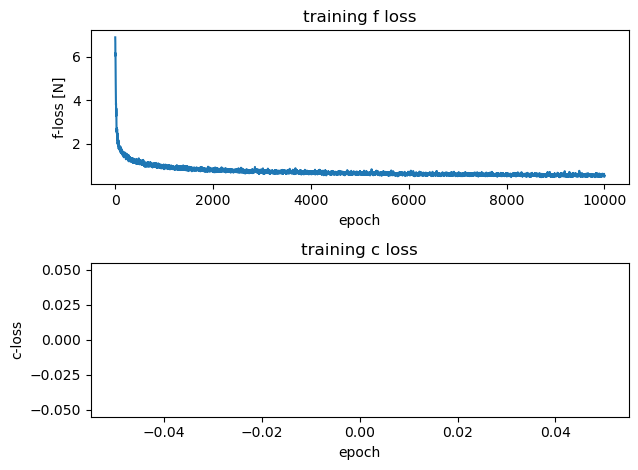

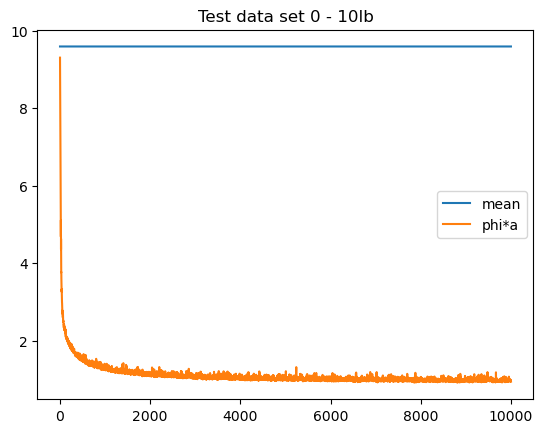

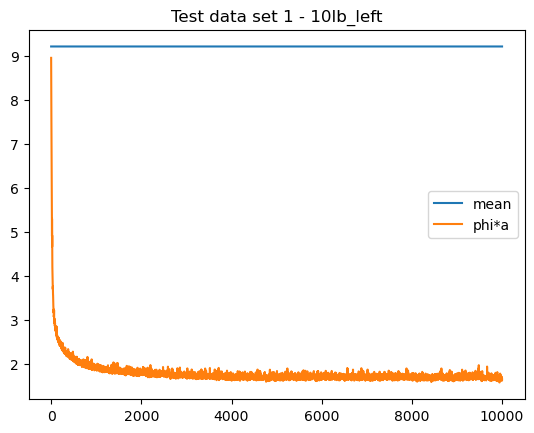

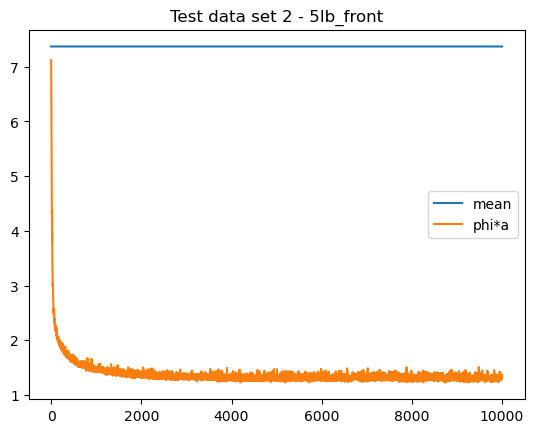

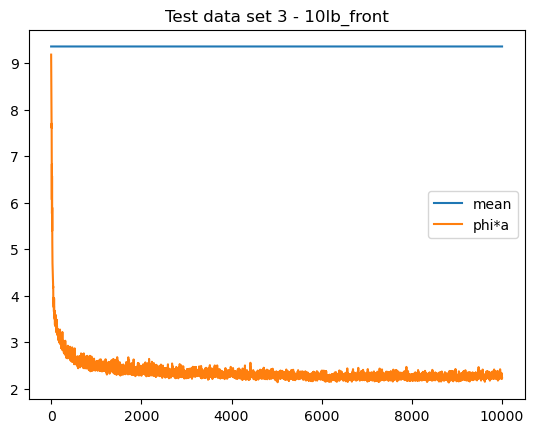

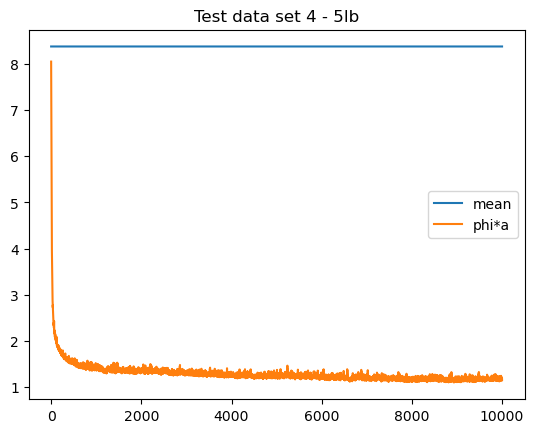

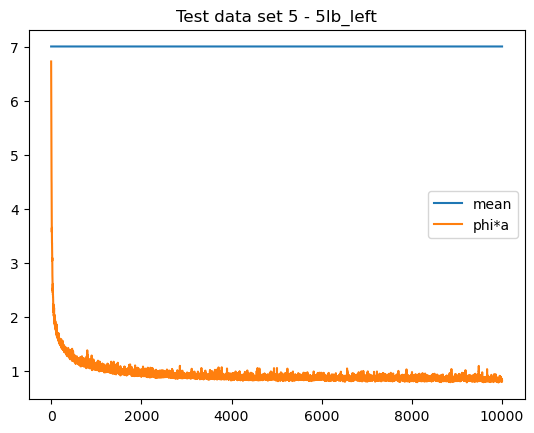

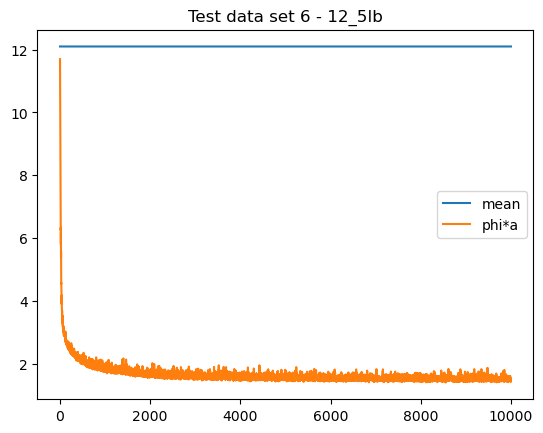

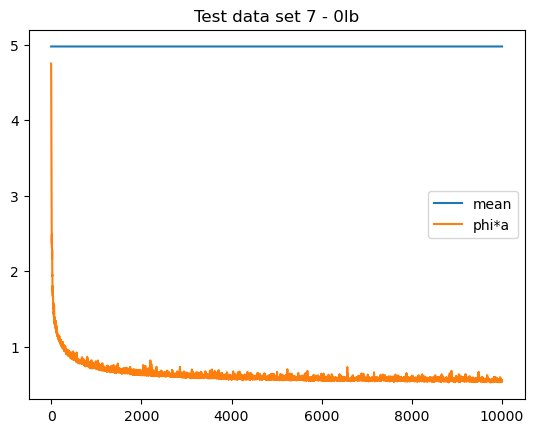

In [13]:
plt.subplot(2, 1, 1)
plt.plot(Loss_f)
plt.xlabel('epoch')
plt.ylabel('f-loss [N]')
plt.title('training f loss')
plt.subplot(2, 1, 2)
plt.plot(Loss_c)
plt.title('training c loss')
plt.xlabel('epoch')
plt.ylabel('c-loss')
plt.tight_layout()

for j in range(len(TestData)):
    plt.figure()
    # plt.plot(Loss_test_nominal[j], label='nominal')
    plt.plot(Loss_test_mean[j], label='mean')
    plt.plot(np.array(Loss_test_phi[j]), label='phi*a')
    # plt.plot(np.array(Loss_test_exp_forgetting[j]), label='exp forgetting')
    plt.legend()
    plt.title(f'Test data set {j} - {TestData[j].meta["condition"]}')

plt.show()

In [14]:
# Choose final model
# stopping_epoch = 200
# options['num_epochs'] = stopping_epoch

model_path = os.path.join(options["output_path"], "models", (modelname + '-epoch-' + str(options["num_epochs"])))
# model_path = os.path.join("/home/hcr/Research/DARoSLab/rina/training_results/06_18_202414_26_27_cmd_residual_baseline_no_dis_debug/models", (modelname + '-epoch-' + str(2000)))
final_model = mlmodel.load_model_e2e(modelname = model_path)

In [15]:
phi_net = final_model.phi
h_net = final_model.h

eval_adapt_start = 0
eval_adapt_end = 2500
eval_val_start = 2500
eval_val_end = 5000

vis_output_path_prefix_training_data = os.path.join(options["output_path"], "eval_images", "training")
vis_output_path_prefix_testing_data = os.path.join(options["output_path"], "eval_images", "testing")

# vis_output_path_prefix_training_data = os.path.join("/home/hcr/Research/DARoSLab/rina/training_results/06_18_202414_26_27_cmd_residual_baseline_no_dis_debug/eval_images/training")
# vis_output_path_prefix_testing_data = os.path.join("/home/hcr/Research/DARoSLab/rina/training_results/06_18_202414_26_27_cmd_residual_baseline_no_dis_debug/eval_images/testing")

Plot the measured aerodynamic force, labeled ground truth (gt), along with the region used for adapation (adapt), and the predicted region (val)

In [16]:
phi_net.to(device)

for i, data in enumerate(Data):
    print('------------------------------')
    print(data.meta['condition'] + ':')
    file_name = "{:s}.png".format(data.meta['condition'])
    mlmodel.vis_validation_e2e(t=data.meta['steps'], x=data.X, y=data.Y, phi_net=phi_net, 
                           h_net=h_net, 
                           idx_val_start=eval_val_start, idx_val_end=eval_val_end, c=Data[i].C, options=options, 
                           output_path_prefix=vis_output_path_prefix_training_data, output_name=file_name)

------------------------------
10lb:
------------------------------
5lb:
------------------------------
0lb:


<Figure size 1500x1200 with 0 Axes>

<Figure size 1500x1200 with 0 Axes>

<Figure size 1500x1200 with 0 Axes>

In [17]:
for data in Data:
    image_name = "{:s}_errors_hist.png".format(data.meta['condition'])
    error_1, error_2, error_3 = mlmodel.error_statistics_hist_e2e(data.X, data.Y, phi_net, h_net, options, vis_output_path_prefix_training_data, image_name)
    print('**** c =', str(data.C), ':', data.meta['condition'], '****')
    print(f'Before learning: MSE is {error_1: .2f}')
    print(f'Mean predictor: MSE is {error_2: .2f}')
    print(f'After learning phi(x): MSE is {error_3: .2f}')
    print('')

**** c = 0 : 10lb ****
Before learning: MSE is  9.86
Mean predictor: MSE is  9.54
After learning phi(x): MSE is  0.77

**** c = 1 : 5lb ****
Before learning: MSE is  7.16
Mean predictor: MSE is  6.98
After learning phi(x): MSE is  0.52

**** c = 2 : 0lb ****
Before learning: MSE is  5.13
Mean predictor: MSE is  5.07
After learning phi(x): MSE is  0.48



## Test Data Error Analysis

In [18]:
for i, data in enumerate(TestData):
    print('------------------------------')
    print(data.meta['condition'] + ':')
    print(len(data.X))
    file_name = "{:s}.png".format(data.meta['condition'])
    mlmodel.vis_validation_e2e(t=data.meta['steps'], x=data.X, y=data.Y, phi_net=phi_net, h_net=h_net, 
                           idx_val_start=eval_val_start, idx_val_end=eval_val_end, c=TestData[i].C, options=options,
                           output_path_prefix=vis_output_path_prefix_testing_data, output_name=file_name)

------------------------------
10lb:
67489
------------------------------
10lb_left:
68191
------------------------------
5lb_front:
67628
------------------------------
10lb_front:
66847
------------------------------
5lb:
66871
------------------------------
5lb_left:
67382
------------------------------
12_5lb:
59776
------------------------------
0lb:
65366


<Figure size 1500x1200 with 0 Axes>

<Figure size 1500x1200 with 0 Axes>

<Figure size 1500x1200 with 0 Axes>

<Figure size 1500x1200 with 0 Axes>

<Figure size 1500x1200 with 0 Axes>

<Figure size 1500x1200 with 0 Axes>

<Figure size 1500x1200 with 0 Axes>

<Figure size 1500x1200 with 0 Axes>

In [19]:
pred_errors = []

for data in TestData:
    image_name = "{:s}_errors_hist.png".format(data.meta['condition'])
    error_1, error_2, error_3 = mlmodel.error_statistics_hist_e2e(data.X, data.Y, phi_net, h_net, options, vis_output_path_prefix_testing_data, image_name)
    print('**** :', data.meta['condition'], '****')
    print(f'Before learning: MSE is {error_1: .2f}')
    print(f'Mean predictor: MSE is {error_2: .2f}')
    print(f'After learning phi(x): MSE is {error_3: .2f}')
    print('')
    pred_errors.append(error_3)


np.mean(pred_errors)

**** : 10lb ****
Before learning: MSE is  9.92
Mean predictor: MSE is  9.59
After learning phi(x): MSE is  0.94

**** : 10lb_left ****
Before learning: MSE is  9.57
Mean predictor: MSE is  9.21
After learning phi(x): MSE is  1.66

**** : 5lb_front ****
Before learning: MSE is  7.56
Mean predictor: MSE is  7.37
After learning phi(x): MSE is  1.31

**** : 10lb_front ****
Before learning: MSE is  9.69
Mean predictor: MSE is  9.35
After learning phi(x): MSE is  2.23

**** : 5lb ****
Before learning: MSE is  8.56
Mean predictor: MSE is  8.38
After learning phi(x): MSE is  1.15

**** : 5lb_left ****
Before learning: MSE is  7.22
Mean predictor: MSE is  7.01
After learning phi(x): MSE is  0.83

**** : 12_5lb ****
Before learning: MSE is  12.49
Mean predictor: MSE is  12.10
After learning phi(x): MSE is  1.51

**** : 0lb ****
Before learning: MSE is  5.03
Mean predictor: MSE is  4.97
After learning phi(x): MSE is  0.55



1.2742364275941203

In [20]:
# # model_path = os.path.join(options["output_path"], "models", (modelname + '-epoch-' + str(options["num_epochs"])))
# model_path = os.path.join("/home/oyoungquist/Research/RINA/rina/training_results/baseline_models/extended_state/07_03_202416_30_31_cmd_residual_cc_baseline_no_dis_no_sn/models", (modelname + '-epoch-' + str(2000)))
# final_model = mlmodel.load_model_e2e(modelname = model_path)

In [21]:
final_model.phi.cpu()

# convert the trained python model to a Torch.Script model
# An example input you would normally provide to your model's forward() method.
example = torch.rand(1, 40).cpu()

# Use torch.jit.trace to generate a torch.jit.ScriptModule via tracing.
traced_script_module = torch.jit.trace(final_model.phi, example)

# Use torch.jit.trace to generate a torch.jit.ScriptModule via tracing.
traced_script_module = torch.jit.trace(final_model.phi, example)

# testing the traced output
print(traced_script_module(example))

traced_script_module.cpu()

# save-out the scripted model
traced_script_module.save(os.path.join(options["output_path"], "baseline_mlp_extended_state.pt"))

tensor([[ 0.5189,  0.2475, -0.0677, -1.7757, -0.9090,  0.0401, -1.1777,  1.4673,
          1.3115,  0.6447,  0.4087,  0.9245]], grad_fn=<AddmmBackward0>)
